In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn import preprocessing
#from astropy.io import fits,ascii
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from keras import backend as K
import GetLightcurves as gc

In [7]:
def dice_coeff(y_true, y_pred):
    smooth = 0.00001
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection +smooth) / (tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) +smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def weightFocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA): 
    w = tf.reduce_sum(targets,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 - w
    #w = 1 / (w  + 0.00001)
    #w = w**2
    w=tf.cast(w,tf.float32)   
    
    #inputs = K.flatten(inputs)
    #targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(w*K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    #w = 1 / (w  + 0.00001)
    w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def focal_dice_loss(y_true, y_pred):
    loss = FocalLoss(y_true, y_pred) + 1.5*dice_loss(y_true, y_pred)
    return loss

#print(weightFocalLoss(Ytest, np.ones((len(Ytest),4000,3),dtype='float32')))
#check score
def corr(y_true, y_pred):
    #wholesome thing.... lets see if this is any better
    corrects = 0 
    incorrects = 0
    cm=[[0,0],[0,0]]
    pred_arr=[]
    for i in range(0, len(y_true)):
        tmp=[0,0]
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        #newpl=np.asarray([1 if(el>np.mean(newpl)+np.std(newpl)) else 0 for el in newpl])
        #newfps=np.asarray([1 if(el>np.mean(newfps)+np.std(newfps)) else 0 for el in newfps])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]): 
                corrects+=1
                cm[0][0]+=1
                tmp[0]=1
            else: 
                incorrects+=1
                cm[1][0]+=1
                tmp[1]=1
            #print(val1[0,1], val2[0,1])
        #fps detect
        if(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                corrects+=1
                cm[1][1]+=1
                tmp[1]=1
            else: 
                cm[0][1]+=1
                incorrects+=1
                tmp[0]=1
            #print(val1[0,1], val2[0,1])
        pred_arr.append(tmp)
        #planet detection:
    
    print(corrects, incorrects)
    print(np.asarray(cm)/np.asarray(cm).sum())
    print(corrects/(corrects+incorrects))

def corrarr(y_true, y_pred):
    checkarr=[]
    for i in range(0, len(y_true)):
        newpl=np.asarray(y_pred[i,:,0])
        newfps=np.asarray(y_pred[i,:,1])
        if(np.any(y_true[i,:,0]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,0])
            val2 = np.corrcoef(newpl, y_true[i,:,0])
            if(val2[0,1]>val1[0,1]):
                checkarr.append(0)
            else: 
                checkarr.append(1)
            #print(val1[0,1], val2[0,1])
        #fps detect
        elif(np.any(y_true[i,:,1]>0)):
            val1 = np.corrcoef(newfps, y_true[i,:,1])
            val2 = np.corrcoef(newpl, y_true[i,:,1])
            if(val1[0,1]>val2[0,1]): 
                checkarr.append(0)
            else: 
                checkarr.append(1)
    return(checkarr)

In [136]:
def generate_anomaly(arr, frac):
    arr = np.asarray(arr)
    l = int(frac*np.asarray(arr>0).sum())
    print(l)
    rarr = np.random.uniform(1.1, 1.8, l)
    place = np.where(arr>0)[0]
    np.random.shuffle(place)
    place = place[:l]
    narr = []
    x=0
    for i in range(len(arr)):
        if(np.any(place==i)): 
            narr.append(arr[i]/rarr[x])
            x+=1
        else: narr.append(arr[i])

    return(np.asarray(narr))

def get_chunks_from_record(filename, binip, binop):
    dfn,dfy,dfc = gc.read_tfr_record(filename,
            ['input','mask','counts'],['ar','ar','ar'], 
            [tf.float32, tf.bool, tf.int8])
    dfy = np.reshape(np.asarray(dfy),(len(dfn),4000,3))
    df = np.concatenate(np.asarray(dfy[:,:,0]), axis=0)
    df = generate_anomaly(df, 0.02)
    #df = df-np.median(df)
    #df = df/np.abs(min(df))

    xarr=np.asarray([df[i:i+binip] for i in range(0,len(df)-binip, binop)])
    yarr=np.asarray([df[i+binip:i+binip+binop] for i in range(0,len(df)-binip, binop)])
    print("shapes:",xarr.shape, yarr.shape)
    return (xarr, yarr)

def predictor(imsz, opsize):
    conv_ip = keras.layers.Input(shape=(imsz,),name='Input')
    xi=keras.layers.Reshape((imsz, 1), input_shape=(imsz,),name='reshape_1')(conv_ip)
    xi=keras.layers.BatchNormalization()(xi)
    xi=keras.layers.GRU(32, return_sequences=True,name="GRU_lay_2",activation='tanh')(xi)
    #xi=keras.layers.Conv1D(32, kernel_size=5,name="GRU_lay_2",activation='tanh')(xi)
    xi=keras.layers.MaxPool1D(2,strides=2,data_format='channels_last',name='maxpool_1')(xi)  
    xi=keras.layers.GRU(64, return_sequences=True,name="GRU_lay_3",activation='tanh')(xi) 
    #xi=keras.layers.Conv1D(64, kernel_size=5,name="GRU_lay_3",activation='tanh')(xi)
    xi=keras.layers.MaxPool1D(2,strides=2,data_format='channels_last',name='maxpool_2')(xi)
    #xi=keras.layers.GRU(64, return_sequences=True,name="GRU_lay_4",activation='tanh')(xi) 
    xi=keras.layers.Flatten()(xi)
    xi=keras.layers.Dense(64,activation='relu')(xi)
    conv_op=keras.layers.Dense(opsize,activation='relu')(xi)

    keras.backend.clear_session()
    convNN = keras.Model(inputs=conv_ip, outputs=conv_op,name='Convolutional_NN')

    convNN.summary()
    convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
    return(convNN)

def train_model(model, xarr, yarr, start=0, count=300, random=False):
    if(random):
        shar=np.arange(0,len(xarr))
        np.random.shuffle(shar)
        xarrf=np.asarray([xarr[i] for i in shar])
        yarrf=np.asarray([yarr[i] for i in shar])
    else: 
        xarrf=xarr
        yarrf=yarr
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history=model.fit(xarrf[start:start+count], yarrf[start:start+count], batch_size=8, epochs=50, verbose=1,validation_split=0.2,
        callbacks=[stop_early])
    maxms = model.predict(xarrf[start:start+count])
    mserr = max(((maxms - yarrf[start:start+count])**2).reshape(-1))
    print(mserr)
    return(model, history, mserr)

def test_model(model, xarr, yarr):
    PrMP=model.predict(xarr)
    PrMP=np.concatenate(PrMP)
    PrMP=PrMP.reshape(-1)
    print(PrMP.shape)
    return(PrMP, np.concatenate(yarr))
    
def get_anomalies(predtot, truetot, thres=2):
    difftmp = np.abs(predtot - truetot)
    difftmp = difftmp
    #th = max(difftmp[:20000])
    anarrtmp=difftmp>np.mean(difftmp)+thres*np.std(difftmp)
    #anarrtmp=difftmp>thres
    print(anarrtmp.sum())
    return(anarrtmp)

def plot_anomalies(arr, ind, el, path):
    fig, ax = plt.subplots(1,1, figsize=(12,6))
    count=np.where(np.asarray(ind)>0)[0]
    ax.plot(arr, marker='.', ls='None', label='lc')
    ax.plot(count, arr[count], marker='.', ls='None', label='weird')
    ax.legend()
    ax.set_title(el)
    ax.set_xlabel('pixel')
    ax.set_ylabel('flux')
    plt.savefig(path+el+'_s.png')
    plt.close(fig)



In [14]:
#wholistic code:
INPDIR='../../processed_directories/full_lc_planets/'
OPDIR='../../processed_directories/anomalies_set4/'
entries = os.listdir(INPDIR)
totx=[]
toty=[]
totid=[]
totloss=[]
totvalloss=[]
totpredy=[]
totanom=[]
for el in entries[100:130]:
    x,y = get_chunks_from_record(INPDIR+el,2000,50)
    Mdl = predictor(2000,50)
    Mdl, history, mserr = train_model(Mdl,x,y,0,600,True)
    prdy, ty = test_model(Mdl, x, y)
    anarr = get_anomalies(prdy, ty, mserr/2)
    print(len(prdy), len(ty))

    plot_anomalies(ty, anarr, el, OPDIR)

    totx.append(x)
    toty.append(ty)
    totid.append(el)
    totloss.append(history.history['loss'])
    totvalloss.append(history.history['val_loss'])
    totpredy.append(prdy)
    totanom.append(anarr)

net = np.asarray([[totx[i], toty[i], totid[i], totloss[i], totvalloss[i], totpredy[i], totanom[i]] for i in range(len(totx))], dtype='object')
gc.write_tfr_record(OPDIR+'set4_v3_2',net,['input','true_op','id','loss','val_loss','pred_op','anomaly'],['ar','ar','b','ar','ar','ar','ar'],
    ['float32','float32','string','float32','float32','float32','bool'])

    
    

shapes: (1320, 2000) (1320, 50)
Model: "Convolutional_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2000)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2000, 1)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2000, 1)           4         
_________________________________________________________________
GRU_lay_2 (GRU)              (None, 2000, 32)          3360      
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1000, 32)          0         
_________________________________________________________________
GRU_lay_3 (GRU)              (None, 1000, 64)          18816     
_________________________________________________________________
maxpool_2 (MaxPool

30

In [9]:
#combine the ensemble
INPDIR='../../processed_directories/full_lc_planets/'
OPDIR='../../processed_directories/anomalies_set2/'
tr_opx, anomx = gc.read_tfr_record(OPDIR+'set2',['true_op','anomaly'],['ar','ar'],['float32','bool'])
tr_opy, anomy = gc.read_tfr_record(OPDIR+'set3',['true_op','anomaly'],['ar','ar'],['float32','bool'])
tr_op1 = np.concatenate(np.asarray([tr_opx, tr_opy]), axis=0)
anom1 = np.concatenate(np.asarray([anomx, anomy]), axis=0)

tr_op2, anom2, id2 = gc.read_tfr_record(OPDIR+'set2and3_v2',['true_op','anomaly', 'id'],['ar','ar', 'b'],['float32','bool','string'])
tr_op3, anom3 = gc.read_tfr_record(OPDIR+'set2and3_v3',['true_op','anomaly'],['ar','ar'],['float32','bool'])
tr_op4, anom4 = gc.read_tfr_record(OPDIR+'set2and3_v4',['true_op','anomaly'],['ar','ar'],['float32','bool'])

In [25]:
#combine the ensemble
INPDIR='../../processed_directories/full_lc_planets/'
OPDIR='../../processed_directories/anomalies_set4/'


tr_op2, anom2, id2 = gc.read_tfr_record(OPDIR+'set4_v1',['true_op','anomaly', 'id'],['ar','ar', 'b'],['float32','bool','string'])
tr_op3, anom3 = gc.read_tfr_record(OPDIR+'set4_v2',['true_op','anomaly'],['ar','ar'],['float32','bool'])
tr_op4, anom4 = gc.read_tfr_record(OPDIR+'set4_v3_2',['true_op','anomaly'],['ar','ar'],['float32','bool'])
tr_op5, anom5 = gc.read_tfr_record(OPDIR+'set4_v3',['true_op','anomaly'],['ar','ar'],['float32','bool'])

In [26]:
idf = [str(el)[2:11] for el in id2]
print(idf)

['003115833', '003116412', '003118797', '003120355', '003120904', '003122872', '003122913', '003128552', '003128793', '003217264', '003218908', '003219037', '003219643', '003219995', '003229150', '003230805', '003231341', '003234598', '003234843', '003236705', '003239171', '003239671', '003239945', '003240158', '003244792', '003245969', '003247268', '003248501', '003326377', '003328080']


[False False False ... False False False]


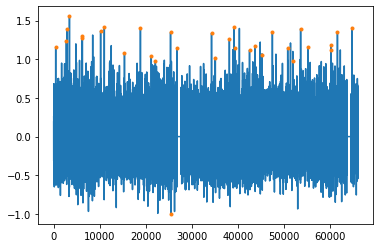

In [27]:
#netanom = np.asarray(anom2) * np.asarray(anom3) * np.asarray(anom4)
netanom = ( np.asarray(anom2, dtype='int') + np.asarray(anom3, dtype='int') + np.asarray(anom5, dtype='int') +
    np.asarray(anom4, dtype='int'))>2
print(netanom[1])
no = 1
plt.plot(tr_op2[no])
count = np.where(netanom[no]>0)[0]
plt.plot(count, np.asarray(tr_op2)[no,count], marker='.', ls='None')

In [32]:

for x in range(0,len(netanom)):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    xax = np.arange(0,len(tr_op2[x]))*29.4/1440
    ax.plot(xax,tr_op2[x], label='lc', marker='.', ls='None')
    ax.set_xlabel('time')
    ax.set_ylabel('flux')
    ax.set_title(idf[x])
    count = np.where(netanom[x]>0)[0]
    ax.scatter(xax[count], np.asarray(tr_op2)[x,count], marker='o', ls='None', label='weird', color='black')
    ax.legend()
    plt.savefig(OPDIR+idf[x]+'_fin.png')
    plt.close()
    

C:\Program Files\Python39\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(60,)
(67980,)
566
shapes: (659, 2000) (659, 100)


(20000.0, 21000.0)

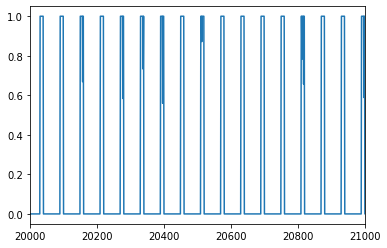

In [134]:
#generate a periodic stream and an anomaly
bit = np.concatenate(np.asarray([np.zeros(50),np.ones(10)]))
print(bit.shape)
inp = np.tile(bit, int(68000/60))
print(inp.shape)

inp = generate_anomaly(inp, 0.05)
binip=2000
binop=100
x=np.asarray([inp[i:i+binip] for i in range(0,len(inp)-binip-binop, binop)])
y=np.asarray([inp[i+binip:i+binip+binop] for i in range(0,len(inp)-binip-binop, binop)])
print("shapes:",x.shape, y.shape)
plt.plot(inp)
plt.xlim(20000,21000)

In [137]:
#wholistic code gen anomaly:
INPDIR='../../processed_directories/full_lc_planets/'
OPDIR='../../processed_directories/'
entries = os.listdir(INPDIR)
el=entries[5]

#x,y = get_chunks_from_record(INPDIR+el,2000,20)
Mdl = predictor(2000,100)
Mdl, history, mserr = train_model(Mdl,x,y,0,300,True)
prdy, ty = test_model(Mdl, x, y)
#mserr = 0.3
anarr = get_anomalies(prdy, ty, mserr/3)
print(len(prdy), len(ty))

plot_anomalies(ty, anarr, el, OPDIR)

net = np.asarray([x, ty, prdy, anarr], dtype='object')
gc.write_tfr_record(OPDIR+'gentest3',net,['input','true_op','pred_op','anomaly'],['ar','ar','ar','ar'],
    ['float32','float32','float32','bool'])


Model: "Convolutional_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2000)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2000, 1)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2000, 1)           4         
_________________________________________________________________
GRU_lay_2 (GRU)              (None, 2000, 32)          3360      
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1000, 32)          0         
_________________________________________________________________
GRU_lay_3 (GRU)              (None, 1000, 64)          18816     
_________________________________________________________________
maxpool_2 (MaxPooling1D)     (None, 500, 64)      

4

2299
65900 65900


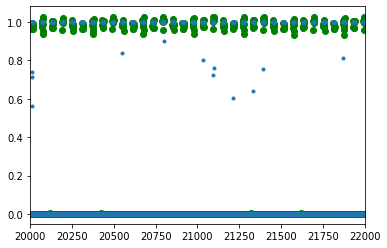

In [144]:
plt.scatter (np.arange(len(prdy)),prdy, color='green')
plt.scatter(np.arange(len(ty)),ty, marker='.')
plt.xlim(20000,22000)
anarr = get_anomalies(prdy, ty, 5)
print(len(prdy), len(ty))
plot_anomalies(ty, anarr, el, OPDIR)

In [9]:
#import data
CV_PATH='../../training_data/cross_validation/'
MN_PATH='../../training_data/'

Xtrain, Mtrain, Otrain, OMtrain = gc.read_tfr_record(MN_PATH+'anomalies_ts2000_100',
    ['input','map','output','opmap'],
    ['ar','ar','ar','ar'], 
    [tf.float32,tf.float32,tf.float32,tf.float32])


In [89]:
Xtrainf=[]
Otrainf=[]
Mtrainf=[]
OMtrainf=[]
for i in range(len(Xtrain)):
    if(not ((-min(Xtrain[i])+np.median(Xtrain[i]))>0) ): continue
    if(not ((-min(Otrain[i])+np.median(Otrain[i]))>0) ): continue
    Xtrainf.append((Xtrain[i]-np.median(Xtrain[i]))/(-min(Xtrain[i])+np.median(Xtrain[i])))
    Otrainf.append((Otrain[i]-np.median(Otrain[i]))/(-min(Otrain[i])+np.median(Otrain[i])))
    Mtrainf.append(Mtrain[i])
    OMtrainf.append(OMtrain[i])

Otrainf = np.asarray(Otrainf)
Xtrainf = np.asarray(Xtrainf)
Mtrainf = np.asarray(Mtrainf)
OMtrainf = np.asarray(OMtrainf)
print(Otrainf.shape, Xtrainf.shape, Mtrainf.shape, OMtrainf.shape)

(9979, 100) (9979, 2000) (9979, 2000) (9979, 100)


In [4]:
convNN=keras.models.load_model('tests.h5',custom_objects={'focal_dice_loss': focal_dice_loss})

In [5]:
pred_op=convNN.predict(Xtest)

NameError: name 'Xtest' is not defined

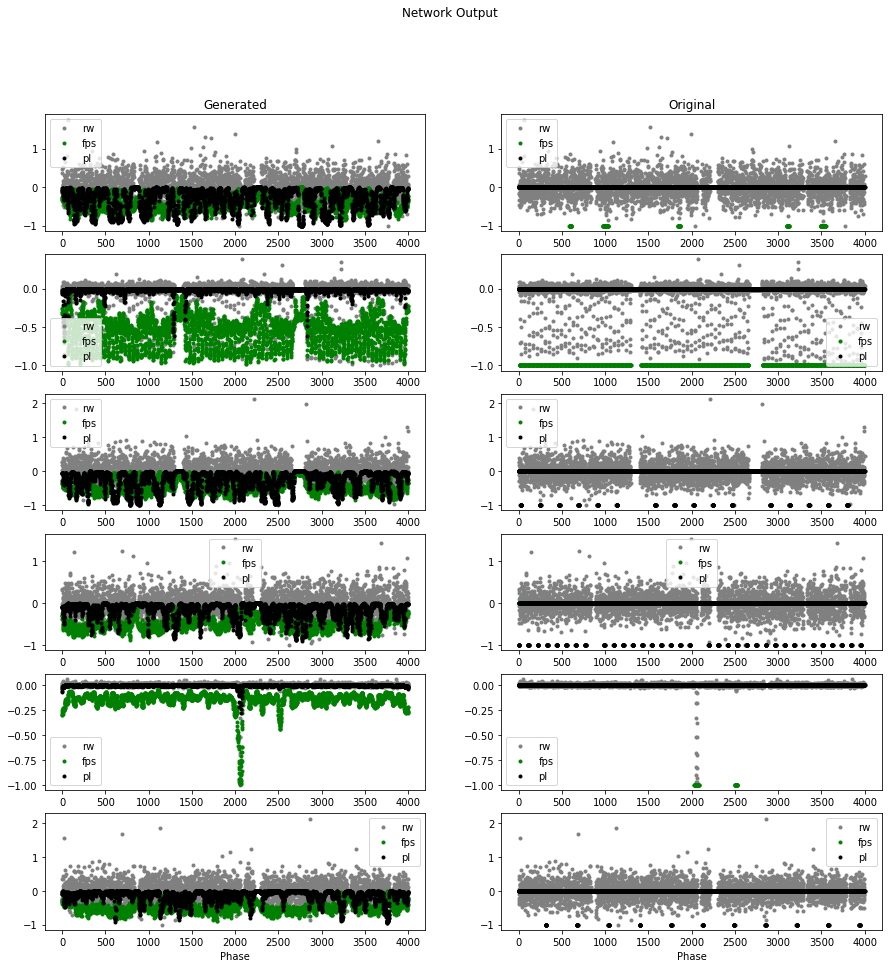

In [10]:
pred_op=np.asarray(pred_op)
fig,ax=plt.subplots(6,2,figsize=(15,15))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
#ar=np.random.randint(len(Xtest),size=10)
ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    m=min(Xtest[ar[i]])
    ax[i][0].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='rw')
    ax[i][0].plot(m*pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(m*pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][1].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='rw')
    ax[i][1].plot(m*Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].plot(m*Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][0].legend('flux')
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')
plt.show()

In [9]:
def gen_ts(map,binip,binop):
    xarr=np.asarray([map[i:i+binip] for i in range(0,len(map)-binip, binop)])
    yarr=np.asarray([map[i+binip:i+binip+binop] for i in range(0,len(map)-binip, binop)])
    return (xarr, yarr)

def remove_nan(red_flux):
    for i in range(0,len(red_flux)):
        if np.isnan(red_flux[i]):
            red_flux[i]=0

'''def open_the_file_and_chunk(filepath, hdu_no, dil_rate):
    hdu = fits.open(filepath)
    flux=hdu[hdu_no].data['LC_DETREND']
    #flux=hdu[len(hdu)-1].data['RESIDUAL_LC']
    tdurs = [hdu[n].header['TPERIOD'] for n in range(1,len(hdu)-1)]
    phase = hdu[hdu_no].data['PHASE']
    
    remove_nan(flux)
    inc=4000*dil_rate
    chunks = np.asarray([flux[np.arange(i,i+inc,dil_rate)] for i in range(0,len(flux)-inc, inc)])
    return(chunks, tdurs, phase)'''

def plot_a_map(input, map):
    totip = np.concatenate(input)
    totop = np.concatenate(map, axis=0)

    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in totop])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    bkg=np.where(counts==2)[0]

    m=min(totip)
    plt.figure(figsize=(10,5))
    plt.title('Total Segmentation Map')
    plt.xlabel('time (days)')
    plt.ylabel('flux')
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,0])
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,1])
    plt.plot(np.asarray(bkg)*29.4/1440,totip[bkg], color='#a4b3b6', marker='.', ls='none', label='bkg')
    plt.plot(np.asarray(fps)*29.4/1440,totip[fps], color='#44318d', marker='.', ls='none', label='fps')
    plt.plot(np.asarray(pl)*29.4/1440,totip[pl], color='#d83f87', marker='.', ls='none', label='pl')
    plt.legend()


In [10]:
FILEPATH = 'E:\Masters_Project_Data\\alienworlds_fps\\'
#kplr004852528-20160128150956_dvt.fits
#kplr011442793-20160128150956_dvt.fits
#kplr008480285-20160128150956_dvt.fits
#kplr011619964-20160128150956_dvt.fits
NAME = 'kplr011619964-20160128150956_dvt.fits'

chunks, tdur, pharr = open_the_file_and_chunk(FILEPATH+NAME,1,1)
print(chunks.shape)
x = min(chunks.reshape(-1))
chunks=np.asarray([(row-np.median(chunks))/(-x+np.median(chunks)) for row in chunks])
#opchunk = convNN.predict(chunks)

(17, 4000)


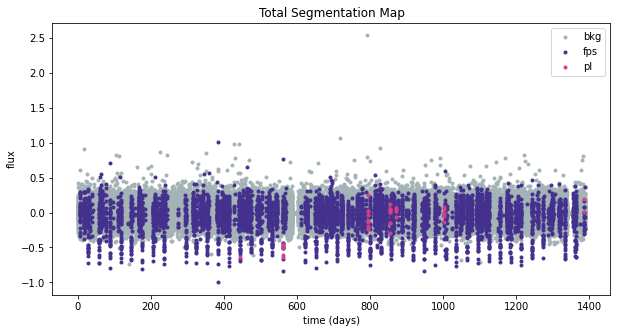

In [8]:
plot_a_map(chunks, opchunk)

In [8]:
PredM = predictor(2000, 50)

Model: "Convolutional_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2000)]            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2000, 1)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2000, 1)           4         
_________________________________________________________________
GRU_lay_2 (GRU)              (None, 2000, 32)          3360      
_________________________________________________________________
maxpool_1 (MaxPooling1D)     (None, 1000, 32)          0         
_________________________________________________________________
GRU_lay_3 (GRU)              (None, 1000, 64)          18816     
_________________________________________________________________
maxpool_2 (MaxPooling1D)     (None, 500, 64)      

In [17]:
XPtr1, YPtr1 = gen_ts(np.concatenate(chunks,axis=0),2000,500)
print(XPtr1.shape, YPtr1.shape)
#XPtr2, YPtr2 = gen_ts(np.concatenate(opchunk,axis=0)[:,1],2000,10)
#print(XPtr2.shape, YPtr2.shape)

#XPtr=np.concatenate(np.asarray([XPtr1,XPtr2]))
#YPtr=np.concatenate(np.asarray([YPtr1,YPtr2]))


(132, 2000) (132, 500)


In [10]:
#print(np.asarray(Mtrain).shape, np.asarray(OMtrain).shape)
Xtr, Xtst, Otr, Otst = train_test_split(XPtr1, YPtr1, test_size=0.6)
print(Xtr.shape, Otr.shape, Xtst.shape)

(528, 2000) (528, 50) (792, 2000)


In [11]:
history=PredM.fit(XPtr1[:600], YPtr1[:600], batch_size=8, epochs=30, verbose=1,validation_split=0.2)

Epoch 1/30
60/60 [==============================] - 18s 152ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 2/30
60/60 [==============================] - 8s 140ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 3/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 4/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 5/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 6/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 7/30
60/60 [==============================] - 8s 140ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/30
60/60 [==============================] - 8s 139ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 10/30
60/60 [==============================] - 8s 139ms/step - loss: 9.9098e-04 - val_loss: 0

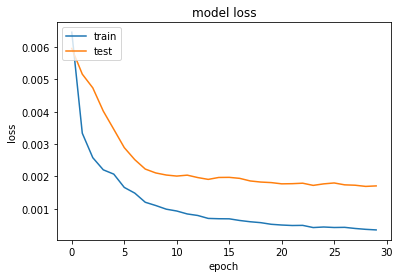

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('fprez_segment.png')
plt.show()

In [59]:
test_op=PredM.predict(XPtr1[:600])
thresmax = max(np.asarray((test_op-YPtr1[:600])**2).reshape(-1))
print(thresmax)


0.74164075


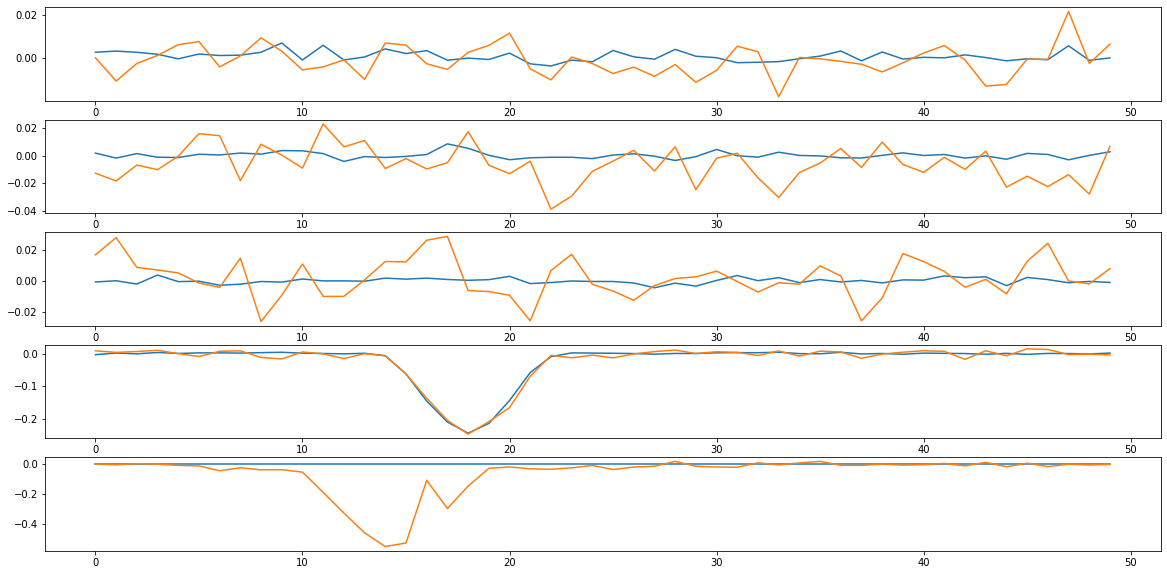

In [14]:
fig, ax = plt.subplots(5,1,figsize=(20,10))
for i in range(0,5):
    ax[i].plot(Otst[i+10])
    ax[i].plot(1*test_op[i+10])

plt.show()

In [11]:
PredM.load_weights('anomaly_take3_maptrain_wts')

In [15]:
XPtrtmp, YPtrtmp = gen_ts(np.concatenate(chunks), 2000, 50)

PrMP2=PredM.predict(XPtrtmp)
#PrMP1=PredM.predict(XPtr1)
#PrMP1=np.concatenate(PrMP1)
PrMP2=np.concatenate(PrMP2)
PrMP2=PrMP2.reshape(-1)
print(PrMP2.shape)

(66000,)


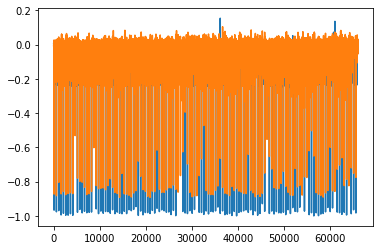

In [16]:
#plt.plot(pred_op[1,1000:,1])
plt.plot(np.concatenate(chunks,axis=0)[2000:,])
plt.plot(1*PrMP2)
#plt.xlim(1000,10000)
#plt.plot(Ytest[1,1000:,1])
#print((np.concatenate(chunks,axis=0)[2000:,]).shape())

In [17]:
#diff2=np.concatenate(opchunk,axis=0)[2000:,1]-PrMP2
#diff2=diff2**2
#diff1=np.concatenate(opchunk,axis=0)[2000:,0]-PrMP1
#diff1=diff1**2

difftmp=np.concatenate(chunks,axis=0)[2000:]-1*PrMP2
difftmp = difftmp**2

In [64]:
'''print((diff1>np.mean(diff1)+2*np.std(diff1)).sum())
print((diff2>np.mean(diff2)+2*np.std(diff2)).sum())
anarr1=diff1>np.mean(diff1)+2*np.std(diff1)
anarr2=diff2>np.mean(diff2)+2*np.std(diff2)'''

anarrtmp=difftmp>np.mean(difftmp)+2*np.std(difftmp)

print(anarrtmp.sum())

205


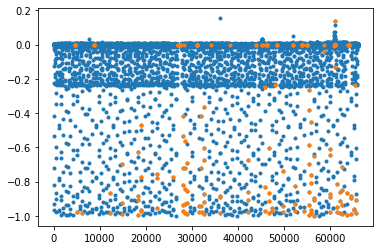

In [65]:
opraw=np.concatenate(chunks)[2000:]
plt.plot(opraw,marker='.', ls='None')
#count1=np.where(anarr1>0)[0]
#count2=np.where(anarr2>0)[0]
count=np.where(anarrtmp>0)[0]
#count=np.intersect1d(count1, count2)
#plt.plot(count1,opraw[count1],marker='.', ls='None')
plt.plot(count,opraw[count],marker='.', ls='None')
#plt.xlim(35075,35125)

[10.368553169834414, 10.368555151189714, 361.0983139984326]


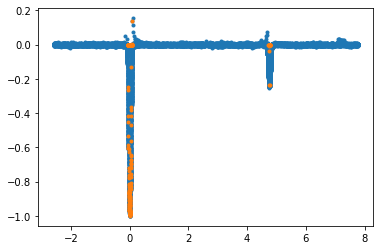

In [66]:
print(tdur) 
phase=pharr[2000:68000]
plt.plot(phase, opraw, marker='.', ls='None')
plt.plot(phase[count],opraw[count],marker='.', ls='None')
#plt.xlim(4.5,5)
#plt.xlim(-0.1,0.1)

In [81]:
from scipy.signal import find_peaks,lombscargle
nt = opraw*anarrtmp < -0.5
p = np.linspace(0.01,300,5000)
print(nt)
f = 2*np.pi /p
predp = lombscargle(np.arange(0,len(nt))*29.4/1440, nt,f, normalize=True)

[False False False ... False False False]


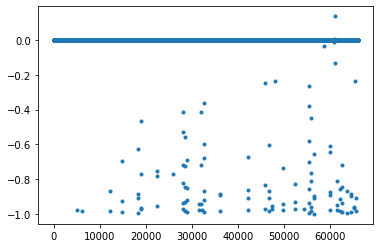

In [87]:
plt.plot(opraw*anarrtmp, marker='.', ls='None')
#plt.plot(p,predp)
#plt.xlim(0,15)

In [42]:
PredM.save('anomaly_take3_maptrain')
PredM.save_weights('anomaly_take3_maptrain_wts')

INFO:tensorflow:Assets written to: anomaly_take3_maptrain\assets


INFO:tensorflow:Assets written to: anomaly_take3_maptrain\assets


In [51]:
#using random forest or k means and all
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA